# Transfer Learning

The process of transfer learning involves taking a pre-trained model and adapting the model to a new, different data set. In this notebook, we will demonstrate how to use transfer learning to train a model to perform image classification on a data set that is different from the data set on which the pre-trained model was trained. 


Transfer learning is really useful when we have a small dataset to train against, and the pre-trained model has been trained on a larger dataset because a small dataset will memorize the data quickly and not work on the new data.

In the previous notebook, we trained a model on the vgg16 model or animal images, we will use the same model to train on the new images. 

In [1]:
from imports import *


sys.path.append("../")
import Utils

device = Utils.get_device()

DATASET_LOCATION = ""
if Utils.in_lab():
    DATASET_LOCATION = "/transfer/dog_door/"
else:
    DATASET_LOCATION = "./dog_door/"

print(f"Dataset location: {DATASET_LOCATION}")
pathlib.Path(DATASET_LOCATION).mkdir(parents=True, exist_ok=True)

Dataset location: ./dog_door/


## Dataset download

In this example (based on the nVidia deep learning course) we are going to download a dataset of a specific dog (Bo the president dog) and a cat. The dataset is available at the following link: https://www.kaggle.com/api/v1/datasets/download/thomaschxu/doggydata

We will then train our model to classify if it is the specific dog or something else. 


In [2]:
url = "https://www.kaggle.com/api/v1/datasets/download/thomaschxu/doggydata"

desitnation = DATASET_LOCATION + "doggydata.zip"
if not pathlib.Path(desitnation).exists():
    Utils.download(url, desitnation)
    Utils.unzip_file(desitnation, DATASET_LOCATION)

# VGG16 Model

we are going to use the vgg16 model which has a 1000 categories, we can now add the new trainable layers to the pre-trained model. 

They will take the features from the pre-trained layers and turn them into predictions on the new dataset. We will add two layers to the model.  Then, we'll add a `Linear` layer connecting all `1000` of VGG16's outputs to `1` neuron to predict if we have the correct dog or not. 

We will now download the pre-trained model and as before and do the setup 

In [3]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

# load the VGG16 network *pre-trained* on the ImageNet dataset
weights = VGG16_Weights.DEFAULT
vgg_model = vgg16(weights=weights)
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

No to create the new layer for our model. 

In [5]:
N_CLASSES = 1
dog_model = nn.Sequential(
    vgg_model,
    nn.Linear(1000, N_CLASSES)
)

dog_model.to(device)

Sequential(
  (0): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

We can verify that the VGG layers are frozen,by looping through the model parameters and checking the `requires_grad` attribute.

In [6]:
for idx, param in enumerate(dog_model.parameters()):
    print(idx, param.requires_grad)

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 True
30 True
31 True
32 True
33 True


for now we do not want to train the VGG layers, we will freeze them.

In [7]:
vgg_model.requires_grad_(False)
print("VGG16 Frozen")

VGG16 Frozen


As we are now classifying only two classes, we will use the binary cross entropy loss, we will use the Adam optimizer and load our model to the device.

In [29]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(dog_model.parameters())
dog_model =dog_model.to(device)

The vgg model has been trained on the ImageNet dataset, this data has a specific format which we need to use. We can get the transforms from the model.

In [9]:
pre_trans = weights.transforms()

We can read in the data (which is in JPG format and infer the labels from the folder structure) and then apply the transforms to the data. The data lives in two folders one for valid and one for train. Within this set we have a folder called bo and one called not_bo.
We can see this here 


In [22]:
directory = pathlib.Path(DATASET_LOCATION+"/data")
folders = [item for item in directory.rglob("*") if item.is_dir()]
for f in folders :
    print(f)


dog_door/data/doggy_door_data
dog_door/data/presidential_doggy_door
dog_door/data/doggy_door_images
dog_door/data/presidential_doggy_door/valid
dog_door/data/presidential_doggy_door/train
dog_door/data/presidential_doggy_door/valid/not_bo
dog_door/data/presidential_doggy_door/valid/bo
dog_door/data/presidential_doggy_door/train/not_bo
dog_door/data/presidential_doggy_door/train/bo


In [25]:
import glob
DATA_LABELS = ["bo", "not_bo"] 
    
class MyDataset(Dataset):
    def __init__(self, data_dir):
        self.imgs = []
        self.labels = []
        
        for l_idx, label in enumerate(DATA_LABELS):
            data_paths = glob.glob(data_dir + label + '/*.jpg', recursive=True)
            for path in data_paths:
                img = Image.open(path)
                self.imgs.append(pre_trans(img).to(device))
                self.labels.append(torch.tensor(l_idx).to(device).float())


    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.imgs)

In [ ]:
batch_size = 32

train_path = DATASET_LOCATION+"data/presidential_doggy_door/train/"
train_data = MyDataset(train_path)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_N = len(train_loader.dataset)

valid_path = DATASET_LOCATION+"data/presidential_doggy_door/valid/"
valid_data = MyDataset(valid_path)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
valid_N = len(valid_loader.dataset)

we can also add colour jitter to our transforms now as we have colour input images.

In [40]:
IMG_WIDTH, IMG_HEIGHT = (224, 224)

random_trans = transforms.Compose([
    transforms.RandomRotation(25),
    *([transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.8, 1), ratio=(1, 1))] if device == 'cuda' else []),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=.2)
])

as we are using BinaryCrossEntropyLoss we need to modify our batch_accuracy function to take into account the fact that we are only predicting one class.

In [36]:
def get_batch_accuracy(output, y, N):
    zero_tensor = torch.tensor([0]).to(device)
    pred = torch.gt(output, zero_tensor)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

In [41]:
def train(model):
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = torch.squeeze(model(random_trans(x)))
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [42]:
def validate(model):
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = torch.squeeze(model(x))

            loss += loss_function(output, y.float()).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

Now for the training. We will train the model for 10 epochs and then save the model.

In [43]:
epochs = 10

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train(dog_model)
    validate(dog_model)

Epoch: 0
Train - Loss: 2.7752 Accuracy: 0.7986
Valid - Loss: 0.7328 Accuracy: 0.6333
Epoch: 1
Train - Loss: 2.0859 Accuracy: 0.8417
Valid - Loss: 0.4715 Accuracy: 0.6333
Epoch: 2
Train - Loss: 1.6149 Accuracy: 0.8705
Valid - Loss: 0.3970 Accuracy: 0.8000
Epoch: 3
Train - Loss: 2.0526 Accuracy: 0.8417
Valid - Loss: 0.3294 Accuracy: 0.8333
Epoch: 4
Train - Loss: 1.8001 Accuracy: 0.8417
Valid - Loss: 0.2555 Accuracy: 0.9333
Epoch: 5
Train - Loss: 1.5456 Accuracy: 0.8705
Valid - Loss: 0.2194 Accuracy: 0.9333
Epoch: 6
Train - Loss: 1.3916 Accuracy: 0.8849
Valid - Loss: 0.1894 Accuracy: 0.9333
Epoch: 7
Train - Loss: 1.6170 Accuracy: 0.8777
Valid - Loss: 0.1606 Accuracy: 0.9667
Epoch: 8
Train - Loss: 1.1923 Accuracy: 0.9137
Valid - Loss: 0.1373 Accuracy: 0.9667
Epoch: 9
Train - Loss: 1.7433 Accuracy: 0.8849
Valid - Loss: 0.1172 Accuracy: 0.9667


We can now save the model and test it. 

In [44]:
# save model
torch.save(dog_model.state_dict(),'dog_model.pth')

In [47]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_prediction(file_path):
    show_image(file_path)
    image = Image.open(file_path)
    image = pre_trans(image).to(device)
    image = image.unsqueeze(0)
    output = dog_model(image)
    prediction = output.item()
    return prediction

We can test against some of the data we used to train the model and see how well it performs.

-3.867579936981201

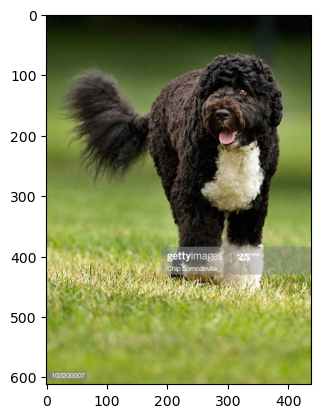

In [48]:
make_prediction(DATASET_LOCATION+'data/presidential_doggy_door/valid/bo/bo_20.jpg')

5.68267297744751

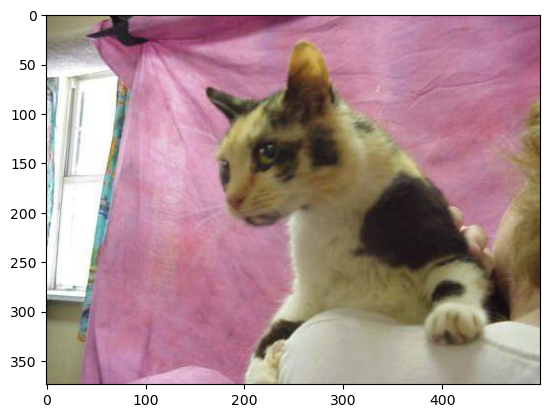

In [49]:
make_prediction(DATASET_LOCATION+'data/presidential_doggy_door/valid/not_bo/121.jpg')

A Negative number means that the model is predicting the correct class so we can see that the model is working well.